In [15]:
import tensorflow_datasets as tfds
import tensorflow as tf

dataset_name = 'horses_or_humans'  

(dataset_train, dataset_test), metadata = tfds.load(
    name=dataset_name,
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)
# dataset_train, info =  tfds.load(name=dataset_name , split=tfds.Split.TRAIN, with_info=True)
# dataset_test, info =  tfds.load(name=dataset_name , split=tfds.Split.TEST, with_info=True)

In [16]:
print(dataset_train)
print(dataset_test)

<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


In [60]:
IMG_SIZE = 224 
def preprocess(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [61]:
train = dataset_train.map(preprocess)
validation = dataset_test.map(preprocess)

In [62]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

In [63]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [64]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [65]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False

(32, 7, 7, 1280)


In [66]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [67]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [71]:
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [72]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [73]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
26/26 [==============================] - 35s 1s/step - loss: 1.0344 - accuracy: 0.4732 - val_loss: 0.7164 - val_accuracy: 0.5756
Epoch 2/10
26/26 [==============================] - 35s 1s/step - loss: 0.5796 - accuracy: 0.7202 - val_loss: 0.4619 - val_accuracy: 0.8000
Epoch 3/10
26/26 [==============================] - 35s 1s/step - loss: 0.3575 - accuracy: 0.8893 - val_loss: 0.2957 - val_accuracy: 0.9317
Epoch 4/10
26/26 [==============================] - 35s 1s/step - loss: 0.2199 - accuracy: 0.9635 - val_loss: 0.1855 - val_accuracy: 0.9805
Epoch 5/10
26/26 [==============================] - 35s 1s/step - loss: 0.1360 - accuracy: 0.9903 - val_loss: 0.1146 - val_accuracy: 0.9951
Epoch 6/10
26/26 [==============================] - 35s 1s/step - loss: 0.0857 - accuracy: 0.9951 - val_loss: 0.0773 - val_accuracy: 0.9951
Epoch 7/10
26/26 [==============================] - 35s 1s/step - loss: 0.0562 - accuracy: 0.9976 - val_loss: 0.0521 - val_accuracy: 0.9951
Epoch 8/10
26/26 [==

In [76]:
test, acc = model.evaluate(validation_batches)
print(acc)

7/7 [==============================] - 6s 891ms/step - loss: 0.0222 - accuracy: 0.9951
0.995121955871582


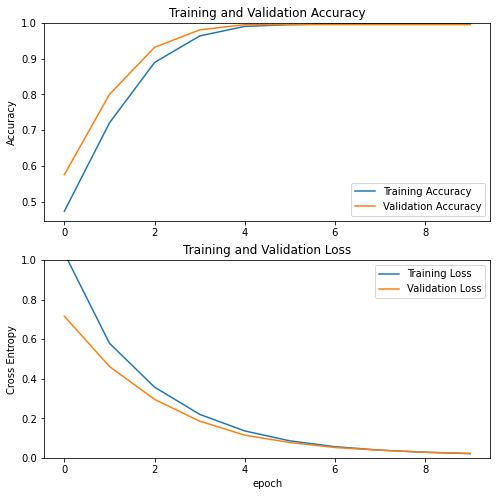

In [77]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()